<a href="https://colab.research.google.com/github/Geethen/NS_carbon/blob/main/code/NS_2_gedi_planet_TCH_NB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extract data for GEDI (tree canopy height) and PlanetScope VNIR percentile data (predictors/covariates) across Kenya.

### Import Packages

If running in Google colab, make sure to install packages that are not readily available, restart kernel and change download directory (dd) after mounting google drive

In [2]:
import ee
# ee.Authenticate()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
import geemap
import geopandas as gpd
# from geeml.utils import createGrid, getCountry
# from geeml.extract import exctractor
# import eerepr

import pandas as pd
import numpy as np

### Configure spatio-temporal parameters

In [ ]:
poi = ee.Geometry.Point([37.857884,-0.002197])
aoi = getCountry(poi)

startDate = '2019-01-01'
endDate = '2020-12-31'

Map = geemap.Map()
Map.addLayer(aoi, {}, 'aoi')
Map.centerObject(aoi, 10)
Map

### Prepare GEDI and planet data for extraction

In [3]:
# Import data
GEDI = ee.ImageCollection("LARSE/GEDI/GEDI02_A_002_MONTHLY")
planet = ee.ImageCollection("projects/planet-nicfi/assets/basemaps/africa")
landcover = ee.ImageCollection("ESA/WorldCover/v100")

aoi = planet.first().geometry()

# Mask to remove buildings, snow/ice/ and open water
lcmask = landcover.filterBounds(aoi).mosaic().eq([50, 70, 80]).reduce(ee.Reducer.max()).eq(0)

# Filter GEDI data (remove low quality data)
def qualityMask(img):
    return img.updateMask(img.select('quality_flag').eq(1))\
          .updateMask(img.select('degrade_flag').eq(0))\
          .updateMask(lcmask)

# Filter data (to aoi and apply qualityMask and select rh98 band)
dataset = GEDI.filterBounds(aoi).map(qualityMask)\
                .select(['rh98'])

# Set projection and scale
projection = dataset.first().projection()
scale = projection.nominalScale()

mosaic = dataset.mosaic().setDefaultProjection(**{'crs':projection, 'scale':5})

# Planet data- get percentiles across all monthly composite planet data
monthlyPlanet = planet.filterBounds(aoi).filterDate('2020-01-01', '2021-01-01').filter(ee.Filter.eq('cadence','biannual')).first()
monthlyPlanet

In [21]:
africa_countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filterBounds(monthlyPlanet.geometry()).filter(ee.Filter.eq('wld_rgn', 'Africa'))

fishnet = geemap.fishnet(aoi.intersection(africa_countries.geometry()), h_interval=1.0, v_interval=1.0, delta=0.5)
# style = {'color': 'ffff00ff', 'fillColor': '00000000'}
# Map.addLayer(fishnet.style(**style), {}, 'Fishnet')

In [22]:
fishnetList = fishnet.toList(167)

In [23]:
for gcell in range(0, 2):
    cell = ee.Feature(fishnetList.get(gcell)).geometry()
    t= monthlyPlanet.clipToBoundsAndScale(
        geometry= cell, scale=100
    )

    monthly_planet_npy = ee.data.computePixels({
        'expression': t,
        'fileFormat': 'NUMPY_NDARRAY'
    })

    print(monthly_planet_npy.shape)

In [24]:
print(monthly_planet_npy.shape)

(1283, 1114)


In [11]:
image_id = monthlyPlanet.getInfo()['id']

# Make a projection to discover the scale in degrees.
proj = ee.Projection('EPSG:4326').atScale(100).getInfo()

# Get scales out of the transform.
scale_x = proj['transform'][0]
scale_y = -proj['transform'][4]

In [12]:
SCALE_FACTOR = 5

jan_mean_temp_npy = ee.data.getPixels({
    'assetId': image_id,
    'fileFormat': 'NUMPY_NDARRAY',
    'grid': {
        'dimensions': {
            'width': 360 * SCALE_FACTOR,
            'height': 180 * SCALE_FACTOR
        },
        'affineTransform': {
            'scaleX': 1 / SCALE_FACTOR,
            'shearX': 0,
            'translateX': -180,
            'shearY': 0,
            'scaleY': -1 / SCALE_FACTOR,
            'translateY': 90
        },
        'crsCode': 'EPSG:4326',
    },
    'bandIds': ['B', 'G', 'R', 'N']
})

jan_mean_temp_npy.shape

(900, 1800)

In [13]:
jan_mean_temp_npy = jan_mean_temp_npy['G']

jan_mean_temp_npy = np.where(jan_mean_temp_npy < -9999, np.nan, jan_mean_temp_npy)
# jan_mean_temp_npy = jan_mean_temp_npy * 0.1
jan_mean_temp_npy

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 955., 955., 955.],
       [  0.,   0.,   0., ..., 955., 955., 955.],
       [  0.,   0.,   0., ..., 955., 955., 955.]])

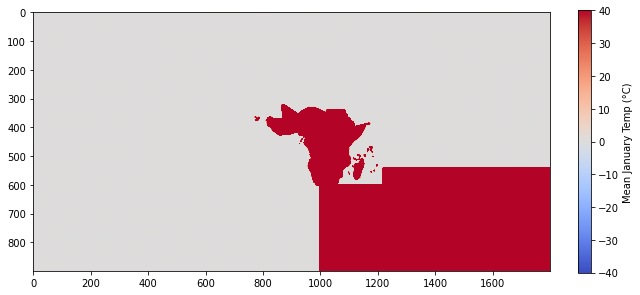

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10., 10.))
ax = plt.imshow(jan_mean_temp_npy, cmap='coolwarm', vmin=-40, vmax=40)

colorbar = plt.colorbar(ax, fraction=0.0235)
colorbar.set_label('Mean January Temp (°C)')

plt.show()

### Extract data

In [ ]:
dd = r"C:\Users\coach\myfiles\conservation\Handover\TCH\Data\inputs\Tabular"

# Extract Planet data at GEDI points
extractor(monthlyPlanet.addBands(mosaic), aoi, scale = 25, dd = dd, target = mosaic, spcvGridSize = 50000, num_threads = 25)\
.extractPoints(gridSize = 20000, batchSize = 10000, filename = 'VNIR_rh98.csv')